## 5.4 CNN visualization

3 ways : 
- intermediate output
- filter
- heatmap

### 5.4.1 Intermediate activation visualization

In [1]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [4]:
# preprocessing on single image
img_path = './data/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


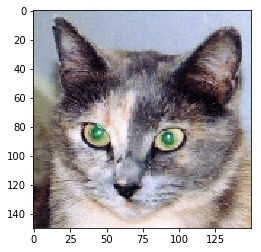

In [5]:
# display test img
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

In [6]:
# model initialization
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, output=layer_outputs)

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("co...)`


In [7]:
# run model with predict mode
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


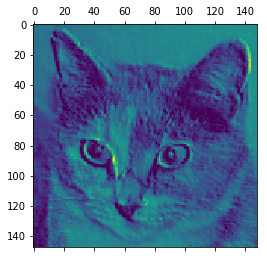

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

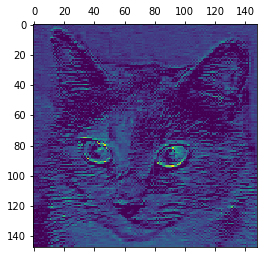

In [10]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


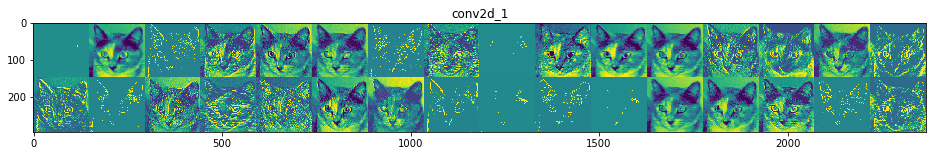

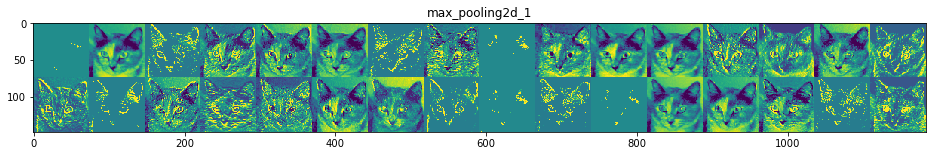

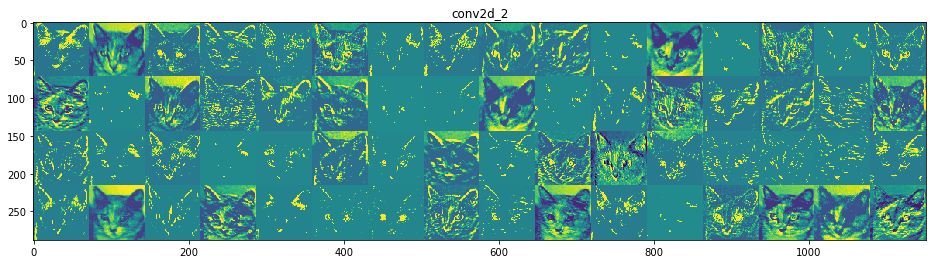

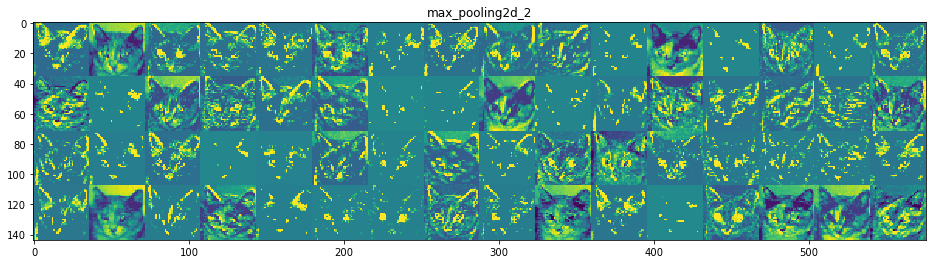

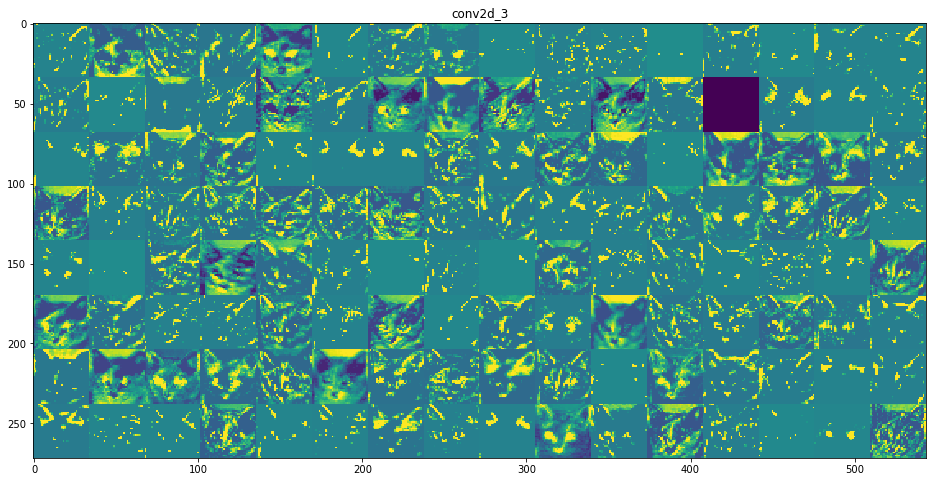

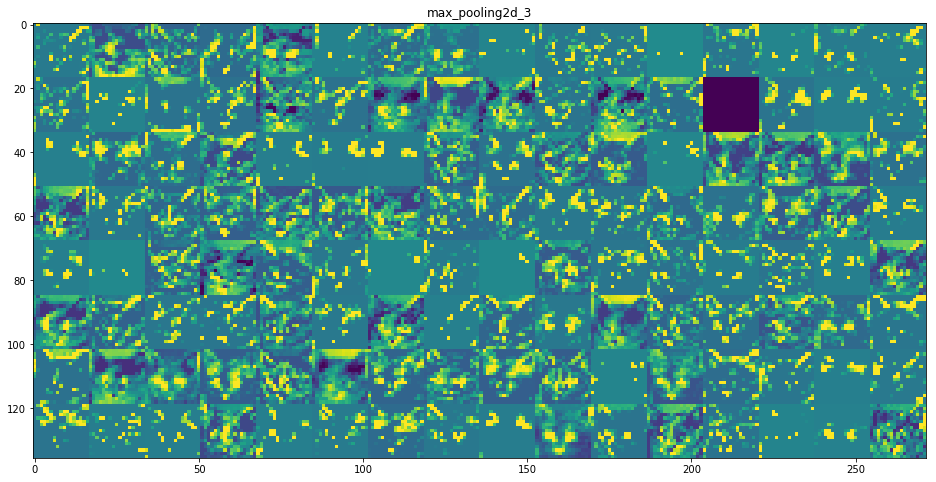

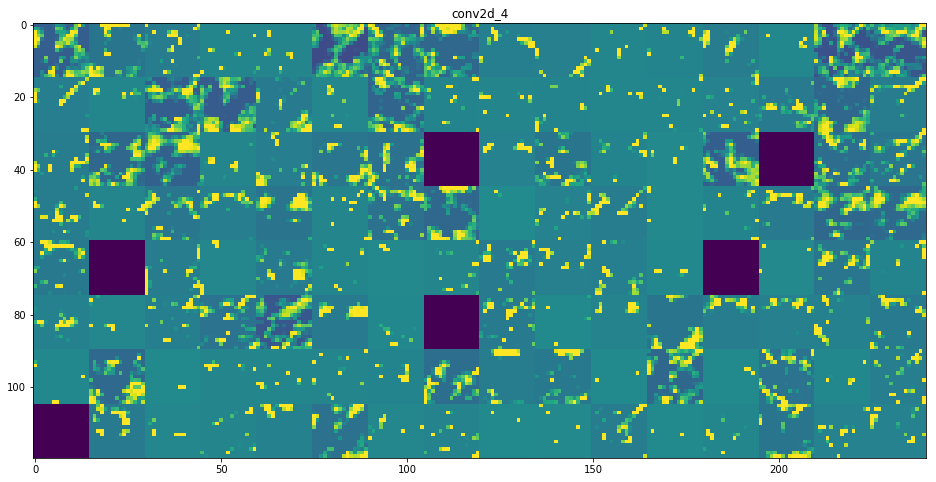

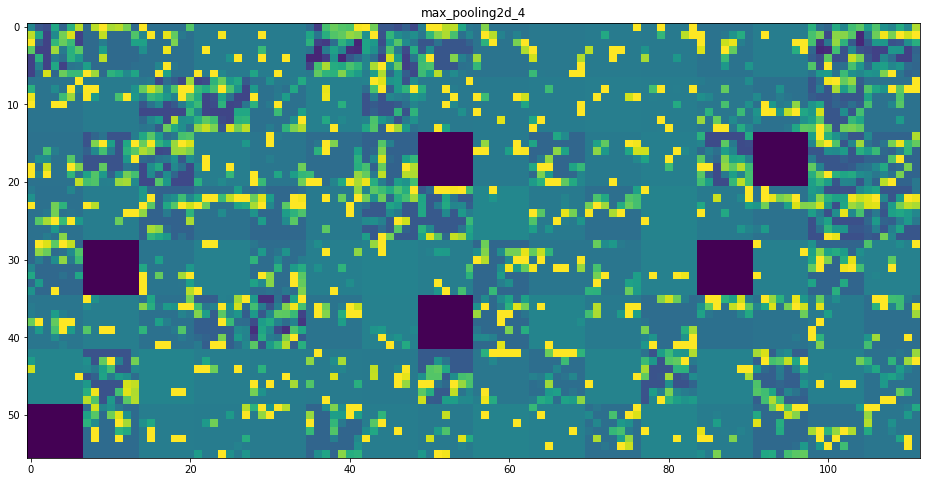

In [13]:
# visualize all channels for each intermediate activation
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
image_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // image_per_row
    display_grid = np.zeros((size * n_cols, image_per_row * size))
    
    for col in range(n_cols):
        for row in range(image_per_row):
            channel_image = layer_activation[0, :, :, col * image_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### 5.4.2 CNN filter visualization

In [1]:
# define tensor for filter
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

Using TensorFlow backend.


In [2]:
# get gradient of loss
grads = K.gradients(loss, model.input)[0]

In [4]:
# gradient normalization
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [5]:
# get numpy output
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [6]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [7]:
input_img_data

array([[[[ 145.16572203,  149.25993374,  131.10994968],
         [ 130.70691962,  135.27179651,  142.8107008 ],
         [ 152.19166093,  147.55156478,  142.47571991],
         ..., 
         [ 148.63099878,  155.13058131,  143.37163734],
         [ 150.63689518,  149.47370034,  138.86197331],
         [ 136.24057414,  147.45287165,  135.91693888]],

        [[ 144.5942286 ,  142.36827191,  152.46096791],
         [ 144.25085023,  153.57621485,  144.28715016],
         [ 160.22566946,  162.26266265,  151.95396579],
         ..., 
         [ 152.71808122,  149.39257075,  140.62397033],
         [ 135.58203717,  134.35838641,  131.94485137],
         [ 149.01224033,  137.27588388,  149.82247992]],

        [[ 157.48905336,  151.19925796,  151.03421747],
         [ 159.4297587 ,  143.53083193,  147.4725393 ],
         [ 148.46054014,  153.11955307,  139.58756302],
         ..., 
         [ 148.47581789,  151.84937284,  133.63206166],
         [ 155.13285463,  140.52917335,  145.47391859],